In [9]:
# ==================================================
# MATCH WINNER PREDICTION PIPELINE
# ==================================================

# Cell 1: Setup and Configuration
# ==================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from pathlib import Path
import warnings
import os
import sys
from datetime import datetime
import optuna

# Sklearn imports
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)

# XGBoost
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost not installed.")

# Configuration
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Paths
MODELS_DIR = Path('models')
VIZ_DIR = Path('visualizations/match_winner')
DATASETS_DIR = Path('datasets')
RAW_MATCH_DATA_PATH = DATASETS_DIR / 'Match Winner.csv'
FINAL_DATA_PATH = Path('data/match_winner/match_winner_data.csv')
REPORTS_DIR = Path('reports/match_winner')

# Create directories
for dir_path in [MODELS_DIR, VIZ_DIR, FINAL_DATA_PATH.parent, REPORTS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Constants
RANDOM_STATE = 42
TEST_SIZE = 0.2

# ==================================================
# UTILITY FUNCTIONS
# ==================================================

def check_data_quality(df):
    """
    Perform comprehensive data quality check.
    """
    print("Data Shape:", df.shape)
    print("\nMissing Values:\n", df.isnull().sum()[df.isnull().sum() > 0])
    print("\nDuplicate Rows:", df.duplicated().sum())
    
    # Check for constant columns
    constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
    if constant_cols:
        print("\nConstant Columns (to drop):", constant_cols)
    else:
        print("\nNo constant columns found.")

def tune_hyperparameters(model_class, X_train, y_train, param_fn, n_trials=20, cv=5, scoring='f1_weighted', task_type='classification'):
    """
    Reusable Optuna hyperparameter tuning function.
    """
    def objective(trial):
        params = param_fn(trial)
        model = model_class(**params)
        
        if task_type == 'classification':
            cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
        else:
            cv_strategy = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
            
        scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring=scoring, n_jobs=-1)
        return scores.mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
        
    return study.best_params

def evaluate_classification_model(model, X_test, y_test, model_name="Model", class_names=None):
    """
    Evaluate classification model and return metrics.
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"--- {model_name} Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1 Score (Weighted): {f1:.4f}")
    
    if y_prob is not None and len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, y_prob[:, 1])
        print(f"ROC AUC: {roc_auc:.4f}")
    
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1
    }

def plot_feature_importance(model, feature_names, top_n=20, model_name="Model"):
    """
    Plot feature importance for tree-based models.
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 8))
        plt.title(f"Feature Importances - {model_name}")
        plt.bar(range(top_n), importances[indices[:top_n]], align="center")
        plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=90)
        plt.xlim([-1, top_n])
        plt.tight_layout()
        plt.show()
    else:
        print(f"{model_name} does not support feature importance plotting.")

print("="*80)
print("MATCH WINNER PREDICTION PIPELINE")
print("="*80)
print(f"Setup completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

MATCH WINNER PREDICTION PIPELINE
Setup completed at: 2025-11-19 17:06:56


In [10]:
# Cell 2: Data Loading and Quality Assessment
# ==================================================

def load_match_data(file_path):
    """
    Load match data and check quality.
    """
    print("\n" + "="*80)
    print("DATA LOADING")
    print("="*80)
    
    if not file_path.exists():
        raise FileNotFoundError(f"File not found: {file_path}")
        
    df = pd.read_csv(file_path)
    
    # Standardize columns
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    # Quality Check
    check_data_quality(df)
    
    print("\nColumns:", df.columns.tolist())
    
    return df

df = load_match_data(RAW_MATCH_DATA_PATH)
df.to_csv(FINAL_DATA_PATH, index=False)


DATA LOADING
Data Shape: (6840, 40)

Missing Values:
 Series([], dtype: int64)

Duplicate Rows: 0

No constant columns found.

Columns: ['unnamed:_0', 'date', 'hometeam', 'awayteam', 'fthg', 'ftag', 'ftr', 'htgs', 'atgs', 'htgc', 'atgc', 'htp', 'atp', 'hm1', 'hm2', 'hm3', 'hm4', 'hm5', 'am1', 'am2', 'am3', 'am4', 'am5', 'mw', 'htformptsstr', 'atformptsstr', 'htformpts', 'atformpts', 'htwinstreak3', 'htwinstreak5', 'htlossstreak3', 'htlossstreak5', 'atwinstreak3', 'atwinstreak5', 'atlossstreak3', 'atlossstreak5', 'htgd', 'atgd', 'diffpts', 'diffformpts']



EDA

Target Distribution (ftr):
ftr
NH    0.535673
H     0.464327
Name: proportion, dtype: float64


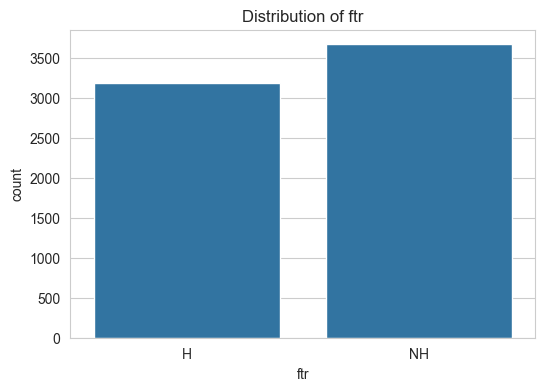

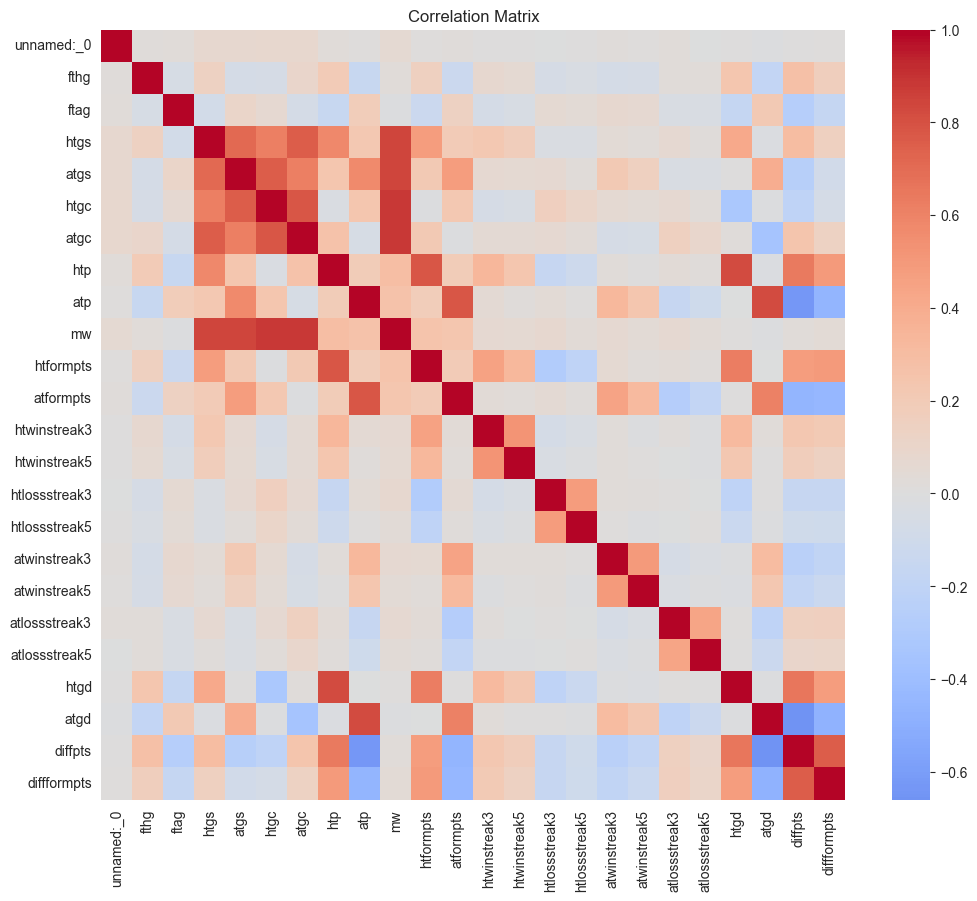

In [11]:
# Cell 3: Exploratory Data Analysis
# ==================================================

def perform_match_eda(df, target_col='ftr'): # ftr = Full Time Result
    """
    EDA for match data.
    """
    print("\n" + "="*80)
    print("EDA")
    print("="*80)
    
    # Target Distribution
    if target_col in df.columns:
        print(f"\nTarget Distribution ({target_col}):")
        print(df[target_col].value_counts(normalize=True))
        
        plt.figure(figsize=(6, 4))
        sns.countplot(x=target_col, data=df)
        plt.title(f'Distribution of {target_col}')
        plt.show()
        
    # Correlations
    numeric_df = df.select_dtypes(include=[np.number])
    if not numeric_df.empty:
        plt.figure(figsize=(12, 10))
        sns.heatmap(numeric_df.corr(), cmap='coolwarm', center=0)
        plt.title('Correlation Matrix')
        plt.show()

# Assuming target is 'ftr' (Full Time Result: H, D, A) or similar
target = 'ftr' 
if target not in df.columns:
    # Try to find target
    possible_targets = ['result', 'winner', 'match_winner']
    for t in possible_targets:
        if t in df.columns:
            target = t
            break

perform_match_eda(df, target_col=target)

In [ ]:
# Cell 4: Feature Engineering and Splitting
# ==================================================

def preprocess_match_features(df, target_col='ftr'):
    """Preprocess match features: remove leakage, encode, split."""
    print("\n" + "="*80)
    print("FEATURE ENGINEERING")
    print("="*80)

    data = df.copy()

    # 1. Remove Leakage (post-match stats that would leak outcome)
    leakage_cols = [
        'fthg', 'ftag', 'hthg', 'htag',  # Goals
        'hs', 'as', 'hst', 'ast',        # Shots
        'hc', 'ac',                      # Corners
        'hf', 'af',                      # Fouls
        'hy', 'ay', 'hr', 'ar'           # Cards
    ]
    cols_to_drop = [c for c in leakage_cols if c in data.columns]
    if cols_to_drop:
        print(f"Dropping leakage columns: {cols_to_drop}")
        data = data.drop(columns=cols_to_drop)

    # 2. Drop non-predictive identifiers (keep team names if you want model to learn team strength)
    drop_cols = ['date', 'referee']  # keep hometeam/awayteam as pre-match info
    dropped_cols = [c for c in drop_cols if c in data.columns]
    if dropped_cols:
        data = data.drop(columns=dropped_cols, errors='ignore')

    print("\n" + "-"*80)
    print("FEATURE SELECTION SUMMARY")
    print("-"*80)
    print(f"Target Column: '{target_col}'")
    print(f"Excluded Columns (Leakage + Non-predictive): {cols_to_drop + dropped_cols}")

    # 3. Encode target if categorical
    le = LabelEncoder()
    if data[target_col].dtype == 'object':
        data[target_col] = le.fit_transform(data[target_col])
        print(f"\nEncoded target classes: {list(le.classes_)}")
    else:
        # Still create label encoder with classes for consistency
        le.classes_ = np.unique(data[target_col])
        print(f"\nTarget classes (numeric): {list(le.classes_)}")

    # 4. Encode categorical feature columns (excluding target)
    cat_cols = data.select_dtypes(include=['object']).columns.tolist()
    if target_col in cat_cols:
        cat_cols.remove(target_col)

    if cat_cols:
        print(f"\nEncoding categorical features: {cat_cols}")
        data = pd.get_dummies(data, columns=cat_cols, drop_first=True)

    # 5. Split features/target
    X = data.drop(columns=[target_col])
    y = data[target_col]

    print(f"\nSelected Feature Columns ({len(X.columns)}):")
    for i, col in enumerate(X.columns, 1):
        print(f"  {i}. {col}")
    print("-"*80)

    # 6. Temporal split if season present, else stratified random
    if 'season' in df.columns:
        print("\nUsing Temporal Split (season)...")
        seasons = sorted(df['season'].unique())
        split_idx = int(len(seasons) * (1 - TEST_SIZE))
        train_seasons = seasons[:split_idx]
        test_seasons = seasons[split_idx:]
        print(f"Training Seasons: {train_seasons}")
        print(f"Test Seasons: {test_seasons}")
        season_mask_train = df['season'].isin(train_seasons)
        season_mask_test = df['season'].isin(test_seasons)
        X_train = X[season_mask_train].drop(columns=['season'], errors='ignore')
        y_train = y[season_mask_train]
        X_test = X[season_mask_test].drop(columns=['season'], errors='ignore')
        y_test = y[season_mask_test]
    else:
        print("\nUsing Stratified Random Split...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
        )

    # 7. Scale numeric features
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

    print(f"\nTraining samples: {len(X_train_scaled)}, Testing samples: {len(X_test_scaled)}")

    return X_train_scaled, X_test_scaled, y_train, y_test, le

X_train, X_test, y_train, y_test, label_encoder = preprocess_match_features(df, target_col=target)

IndentationError: expected an indented block after 'if' statement on line 52 (3728911154.py, line 53)

In [ ]:
# Cell 5: Model Training and Tuning
# ==================================================

def train_match_models(X_train, y_train):
    """
    Train and tune match winner models.
    """
    print("\n" + "="*80)
    print("MODEL TRAINING")
    print("="*80)
    
    best_models = {}
    
    # 1. Logistic Regression
    print("\n--- Tuning Logistic Regression ---")
    def lr_params(trial):
        return {
            'C': trial.suggest_float('C', 0.01, 10.0, log=True),
            'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear']),
            'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
            'max_iter': 1000
        }
        
    lr_best_params = tune_hyperparameters(
        LogisticRegression, X_train, y_train, lr_params, n_trials=20, scoring='accuracy'
    )
    lr_model = LogisticRegression(**lr_best_params)
    lr_model.fit(X_train, y_train)
    best_models['LogisticRegression'] = lr_model
    
    # 2. Random Forest
    print("\n--- Tuning Random Forest ---")
    def rf_params(trial):
        return {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 5, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]),
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        }
    rf_best_params = tune_hyperparameters(
        RandomForestClassifier, X_train, y_train, rf_params, n_trials=20, scoring='accuracy'
    )
    rf_model = RandomForestClassifier(**rf_best_params)
    rf_model.fit(X_train, y_train)
    best_models['RandomForest'] = rf_model
    
    # 3. XGBoost
    if XGB_AVAILABLE:
        print("\n--- Tuning XGBoost ---")
        def xgb_params(trial):
            return {
                'n_estimators': trial.suggest_int('n_estimators', 100, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'random_state': RANDOM_STATE,
                'n_jobs': -1
            }
        xgb_best_params = tune_hyperparameters(
            xgb.XGBClassifier, X_train, y_train, xgb_params, n_trials=20, scoring='accuracy'
        )
        xgb_model = xgb.XGBClassifier(**xgb_best_params)
        xgb_model.fit(X_train, y_train)
        best_models['XGBoost'] = xgb_model
        
    return best_models

best_models = train_match_models(X_train, y_train)

NameError: name 'X_train' is not defined

In [ ]:
# Cell 6: Evaluation
# ==================================================

print("\n" + "="*80)
print("EVALUATION")
print("="*80)

results = []
class_names = list(label_encoder.classes_)

for name, model in best_models.items():
    print(f"\n{'='*60}")
    print(f"Evaluating {name}")
    print(f"{'='*60}")
    
    metrics = evaluate_classification_model(
        model, X_test, y_test, model_name=name, class_names=class_names
    )
    results.append(metrics)
    
    # Feature Importance (Tree models only)
    if name in ['RandomForest', 'XGBoost']:
        print(f"\nFeature Importance for {name}:")
        plot_feature_importance(model, X_train.columns, model_name=name)
        
    # Save
    model_path = MODELS_DIR / f'match_winner_{name}.joblib'
    joblib.dump(model, model_path)
    print(f"\n✓ Model saved to: {model_path}")

# Comparison
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(results_df.to_string(index=False))

results_df.to_csv(REPORTS_DIR / 'model_comparison.csv', index=False)
print(f"\n✓ Comparison saved to: {REPORTS_DIR / 'model_comparison.csv'}")

# Identify best model
best_idx = results_df['F1_Score'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_model = best_models[best_model_name]

# Save best model
best_model_path = MODELS_DIR / 'match_winner_best_model.joblib'
joblib.dump(best_model, best_model_path)
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   F1 Score: {results_df.loc[best_idx, 'F1_Score']:.4f}")
print(f"   Accuracy: {results_df.loc[best_idx, 'Accuracy']:.4f}")
print(f"✓ Best model saved to: {best_model_path}")

# Save metadata
metadata = {
    'pipeline': 'Match Winner Prediction',
    'problem_statement': 'PS4 - Match Winner',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'best_model': best_model_name,
    'target_classes': class_names,
    'metrics': results_df[results_df['Model'] == best_model_name].to_dict('records')[0],
    'all_results': results_df.to_dict('records'),
    'features_used': X_train.columns.tolist(),
    'target_column': target,
    'random_state': RANDOM_STATE,
    'test_size': TEST_SIZE
}

metadata_path = MODELS_DIR / 'ps4_match_winner_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)
print(f"✓ Metadata saved to: {metadata_path}")

print("\n" + "="*80)
print("✅ MATCH WINNER PIPELINE COMPLETED!")
print("="*80)


EVALUATION


NameError: name 'label_encoder' is not defined